# Code for "Identifying neighborhoods for a new restaurant in Atlanta, GA
## Author: Elizabeth Niese
## Date: June 2020

# Data for this project

The neighborhood data is available at https://opendata.arcgis.com/datasets/d6298dee8938464294d3f49d473bcf15_196.geojson.  In this notebook we will 
1. load the data into a pandas dataframe,
2. use the Foursquare API to find venues in each neighborhood,
3. use k-means clustering to group neighborhoods by similar top venues, and
4. show the cluster results on a map and in table format to prepare for analysis.


#### Read the data into a pandas dataframe

We load the packages necessary to read the geojson file into a dataframe.

In [1]:
import pandas as pd #Import pandas library to create dataframs
import requests # library to handle requests
import numpy as np
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

Load the data file containing neighborhood information for Atlanta, GA.

In [2]:
!wget -q -O 'atlanta_data.json' https://opendata.arcgis.com/datasets/d6298dee8938464294d3f49d473bcf15_196.geojson
    
with open('atlanta_data.json') as json_data:  #Load data
    atlanta_data = json.load(json_data)


In [3]:
atlanta_data  #check that data has been loaded

{'type': 'FeatureCollection',
 'name': 'City_of_Atlanta_Neighborhood_Statistical_Areas',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 1,
    'NPU': 'NPU C',
    'STATISTICA': 'C04',
    'POP2010': 2672,
    'NEIGHBORHO': 'Arden/Habersham, Argonne Forest, Peachtree Battle Alliance, Wyngate',
    'URL': 'http://documents.atlantaregional.com/AtlantaProfiles/C04.pdf',
    'A': 'Arden/Habersham, Argonne Forest, Peachtree Battle Alliance, Wyngate',
    'pop': 2672,
    'white': 96.3,
    'black': 0.9,
    'asian': 1.0,
    'other': 0.5,
    'hispanic': 1.3,
    'GlobalID': '{6018B100-48DF-4B88-85B7-C4095D15897D}',
    'last_edited_date': '1970/01/01 00:00:00+00'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-84.40728321312353, 33.8445284540347],
      [-84.40735621368728, 33.84217845397712],
      [-84.40738221308668, 33.842020453850736],
      [-84.40745021353541, 33.84185645

In [4]:
neighborhoods_data = atlanta_data['features']  #create a list of the features in the data
neighborhoods_data

[{'type': 'Feature',
  'properties': {'OBJECTID': 1,
   'NPU': 'NPU C',
   'STATISTICA': 'C04',
   'POP2010': 2672,
   'NEIGHBORHO': 'Arden/Habersham, Argonne Forest, Peachtree Battle Alliance, Wyngate',
   'URL': 'http://documents.atlantaregional.com/AtlantaProfiles/C04.pdf',
   'A': 'Arden/Habersham, Argonne Forest, Peachtree Battle Alliance, Wyngate',
   'pop': 2672,
   'white': 96.3,
   'black': 0.9,
   'asian': 1.0,
   'other': 0.5,
   'hispanic': 1.3,
   'GlobalID': '{6018B100-48DF-4B88-85B7-C4095D15897D}',
   'last_edited_date': '1970/01/01 00:00:00+00'},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-84.40728321312353, 33.8445284540347],
     [-84.40735621368728, 33.84217845397712],
     [-84.40738221308668, 33.842020453850736],
     [-84.40745021353541, 33.84185645344486],
     [-84.40749921310712, 33.84177945347297],
     [-84.4075682136065, 33.84169545317609],
     [-84.40767321307789, 33.8415994532212],
     [-84.40804721333068, 33.84131445349337],
     [-84.408160

We will create a dataframe with column headings for the information we need. Then the data will be loaded into the dataframe using  

In [5]:
column_names = ['Statistical Area', 'Neighborhood', 'Latitude', 'Longitude'] #Create column headings
neighborhoods = pd.DataFrame(columns=column_names)

In the data file, the boundary points for each neighborhood region were given.  To effectively use this information, we need to transform this to a single latitude and longitude for each neighborhood.  We will do this by finding the centroid of each neighborhood.  That is, our latitude for the neighborhood will be the average of the boundary point latitudes, and similarly, the longitude for the neighborhood will be the average of the boundary point longitudes.

In [6]:
#Given a list of boundary points for a region, find the centroid to use as the latitude and longitude for the neighborhood.
def latlong(lst):
    xsum=0.0
    ysum=0.0
    for i in range(len(lst)):
        xsum=xsum+lst[i][0]
        ysum=ysum+lst[i][1]
    lat=ysum/len(lst)
    long=xsum/len(lst)
    return((lat,long))  
     

We load all the data needed into the dataframe.  A couple neighborhood boundaries did not yield usable latitude/longitude information so these will be dropped later. 

In [7]:
for data in neighborhoods_data:  #Load the data into a dataframe
    statarea = data['properties']['STATISTICA'] 
    neighborhood_name = data['properties']['NEIGHBORHO']    
    nlatlong=data['geometry']['coordinates'][0]
    if len(nlatlong)>1:
        truelatlong=latlong(nlatlong)
    if len(nlatlong)==1:
        truelatlong=('NaN','NaN')  #A few neighborhood boundaries are too complex.  We will drop these later.
    lat=truelatlong[0]
    long=truelatlong[1]
    neighborhoods = neighborhoods.append({'Statistical Area': statarea, 'Neighborhood': neighborhood_name,
                                          'Latitude': lat,
                                          'Longitude': long}, ignore_index=True)

We drop rows containing NaN and convert latitude and longitude data types to float.

In [8]:
atl_final=neighborhoods.dropna()  #drop rows with NaN
atl_final.isna().sum()

Statistical Area    0
Neighborhood        0
Latitude            0
Longitude           0
dtype: int64

In [9]:
atl_final.dtypes  #Check data types

Statistical Area    object
Neighborhood        object
Latitude            object
Longitude           object
dtype: object

In [10]:
atl_final['Latitude']=atl_final['Latitude'].astype(float) #cast latitude as a float data type
atl_final['Longitude']=atl_final['Longitude'].astype(float) #cast longitude as a float data type
atl_final.dtypes #verify data types

Statistical Area     object
Neighborhood         object
Latitude            float64
Longitude           float64
dtype: object

In [11]:
atl_final.isna().sum() #check to see if there are rows containing NaN

Statistical Area    0
Neighborhood        0
Latitude            3
Longitude           3
dtype: int64

In [12]:
atl_final.dropna(inplace=True) #drop rows containing NaN

In [13]:
atl_final.isna().sum() #Verify that all rows with NaN have been dropped

Statistical Area    0
Neighborhood        0
Latitude            0
Longitude           0
dtype: int64

Load the packages needed for *K* means clustering and generating maps of the clusters. 

In [14]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c districtdatalabs yellowbrick #Install yellowbrick to use the elbow method

# import k-means from clustering stage
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer  #gives a method to determine optimal k

#Install Folium to generate maps of the clusters.
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    yellowbrick-1.1            |           py36_0         276 KB  districtdatalabs
    pytest-runner-5.2          |             py_0          13 KB
    ------------------------------------------------------------
                                           Total:         289 KB

The following NEW packages will be INSTALLED:

    pytest-runner: 5.2-py_0                   
    yellowbrick:   1.1-py36_0 districtdatalabs


yellowbrick-1.1      | 276 KB    | ##################################### | 100% 
pytest-runner-5.2    | 13 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

In [15]:
# The code was removed by Watson Studio for sharing.

Get coordinates of Atlanta, GA in order to create a map using Folium.

In [16]:
address='Atlanta,GA' #find the latitude and longitude for Atlanta
geolocator = Nominatim(user_agent="atlanta_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Atlanta are {}, {}.'.format(latitude, longitude))

The coordinates of Atlanta are 33.7490987, -84.3901849.


### Create a map of Atlanta with neighborhood markers
Use Folium to create a map of Atlanta, GA.  We populate this map with basic neighborhood markers.  Later we will replot the neighborhoods with color-coding based on which cluster each is assigned.

In [17]:
atlantamap=folium.Map(location=[latitude, longitude], zoom_start=10) #map of Atlanta
#adding neighborhood markers
for lat, lng, neighborhood in zip(atl_final['Latitude'], atl_final['Longitude'], atl_final['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(atlantamap)  
    
atlantamap #Show map of Atlanta with neighborhood markers

Use the Foursquare API to find venues near a given neighborhood.  

In [18]:
# Create a function to find venues near a neighborhood
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
atl_venues_raw = getNearbyVenues(names=atl_final['Neighborhood'],
                                   latitudes=atl_final['Latitude'],
                                   longitudes=atl_final['Longitude']
                                  )
#get venues for atlanta neighborhoods

Arden/Habersham, Argonne Forest, Peachtree Battle Alliance, Wyngate
Peachtree Heights East, Peachtree Hills
Peachtree Heights West
Buckhead Forest, South Tuxedo Park
Chastain Park, Tuxedo Park
East Chastain Park
Garden Hills
Lindbergh/Morosgo
Buckhead Village, Peachtree Park
Vine City
Georgia Tech, Marietta Street Artery
Castleberry Hill, Downtown
Midtown
Home Park
Beecher Hills, Florida Heights, Westwood Terrace
Fort McPherson, Venetian Hills
Sylvan Hills
Capitol View, Capitol View Manor
Bush Mountain, Oakland City
Westview
West End
Ashview Heights, Harris Chiles, Just Us
Atlanta University Center, The Villages at Castleberry Hill
Center Hill, Harvel Homes Community
Dixie Hills, Penelope Neighbors, West Lake
Brandon, Castlewood, Westminster/Milmar, Woodfield
Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek
Hammond Park
Blair Villa/Poole Creek, Glenrose Heights, Orchard Knob, Rosedale Heights
South River Gardens
Perkerson
Ama

In [20]:
atl_venues_raw.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Arden/Habersham, Argonne Forest, Peachtree Bat...",33.828327,-84.398229,Sibley Park,33.828742,-84.394479,Park
1,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,Treehouse Restaurant & Pub,33.818412,-84.381156,American Restaurant
2,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,H & F Bottle Shop,33.819804,-84.387094,Wine Shop
3,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,Zoës Kitchen,33.818941,-84.387863,Mediterranean Restaurant
4,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,Natural Body Spa,33.819971,-84.387580,Spa


In [21]:
print('There are {} unique categories.'.format(len(atl_venues_raw['Venue Category'].unique())))

There are 223 unique categories.


In [22]:
atl_venues_raw['Venue Category'].unique()  #To decide what venues to keep, I wanted to see a list of venue categories

array(['Park', 'American Restaurant', 'Wine Shop',
       'Mediterranean Restaurant', 'Spa', 'Mexican Restaurant',
       'Grocery Store', 'Breakfast Spot', 'Gift Shop',
       'Italian Restaurant', 'Sandwich Place', 'Ice Cream Shop',
       'Shopping Plaza', 'Pharmacy', 'Supplement Shop', "Women's Store",
       'Cosmetics Shop', 'Furniture / Home Store', 'Arts & Crafts Store',
       'Optical Shop', 'Farmers Market', 'Pool', 'Gym / Fitness Center',
       'Gym', 'Café', 'History Museum', 'Soup Place', 'Lounge',
       'Salon / Barbershop', 'Cocktail Bar', 'African Restaurant',
       'Garden Center', 'Supermarket', 'Hardware Store', 'Steakhouse',
       'Fast Food Restaurant', 'Gay Bar', 'Nightclub', 'Thai Restaurant',
       'Video Game Store', 'Wings Joint', 'Big Box Store',
       'Electronics Store', 'Burger Joint', 'Pizza Place', 'Coffee Shop',
       'Clothing Store', 'Asian Restaurant', 'Sports Bar',
       'Shipping Store', 'Residential Building (Apartment / Condo)',
       '

In [23]:
# Want to focus on neighborhoods that have restaurants and high end entertainment

atl_venues_raw['Rest']=atl_venues_raw['Venue Category'].str.contains('Restaurant|Museum|Art|Studio')  #Creates a new column with "True" if the venue is of approved type, and "False" otherwise

In [24]:
atl_venues=atl_venues_raw[atl_venues_raw.Rest!=False]  #only keep venues of type "Restaurant, museum, art, or studio"
atl_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Rest
1,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,Treehouse Restaurant & Pub,33.818412,-84.381156,American Restaurant,True
3,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,Zoës Kitchen,33.818941,-84.387863,Mediterranean Restaurant,True
5,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,Jalisco Mexican Restaurant,33.818999,-84.387506,Mexican Restaurant,True
10,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,Pasta Vino,33.820119,-84.387390,Italian Restaurant,True
12,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,Whitehall Tavern,33.819955,-84.387439,American Restaurant,True


In [25]:
atl_venues.shape

(225, 8)

We use one hot encoding to convert the data and then group by neighborhood to prepare for using the *k* means clustering algorithm.

In [26]:
# one hot encoding
atl_onehot = pd.get_dummies(atl_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
atl_onehot['Neighborhood'] = atl_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [atl_onehot.columns[-1]] + list(atl_onehot.columns[:-1])
atl_onehot = atl_onehot[fixed_columns]

atl_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,...,Science Museum,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
1,"Peachtree Heights East, Peachtree Hills",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Peachtree Heights East, Peachtree Hills",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Peachtree Heights East, Peachtree Hills",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,"Peachtree Heights East, Peachtree Hills",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,"Peachtree Heights East, Peachtree Hills",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#group by neighborhood
atl_grouped = atl_onehot.groupby('Neighborhood').mean().reset_index()
atl_grouped

,Neighborhood,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,...,Science Museum,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,"Adair Park, Pittsburgh",0.0,0.000000,1.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,"Adamsville, Oakcliff",0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Airport,0.0,0.400000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,"Amal Heights, Betmar LaVilla, High Point, Joyland",0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,"Ardmore, Brookwood",0.0,0.090909,0.000000,0.000,0.090909,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.0
5,"Ashview Heights, Harris Chiles, Just Us",0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,"Atkins Park, Virginia Highland",0.0,0.250000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,"Atlanta University Center, The Villages at Cas...",0.0,0.000000,0.000000,1.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,"Atlantic Station, Loring Heights",0.0,0.444444,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,"Baker Hills, Bakers Ferry, Boulder Park, Fairb...",0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Examine top venues and create dataframe organized by top venues for each neighborhood.

In [28]:
num_top_venues = 10  #Show top ten venues for each neighborhood

for hood in atl_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = atl_grouped[atl_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adair Park, Pittsburgh----
                       venue  freq
0                Art Gallery   1.0
1         African Restaurant   0.0
2    Scandinavian Restaurant   0.0
3         Mexican Restaurant   0.0
4  Middle Eastern Restaurant   0.0
5                     Museum   0.0
6    New American Restaurant   0.0
7      Performing Arts Venue   0.0
8         Photography Studio   0.0
9                 Public Art   0.0


----Adamsville, Oakcliff----
                       venue  freq
0       Fast Food Restaurant   0.6
1         Chinese Restaurant   0.2
2         Seafood Restaurant   0.2
3         African Restaurant   0.0
4    Scandinavian Restaurant   0.0
5  Middle Eastern Restaurant   0.0
6                     Museum   0.0
7    New American Restaurant   0.0
8      Performing Arts Venue   0.0
9         Photography Studio   0.0


----Airport----
                       venue  freq
0        American Restaurant   0.4
1                     Museum   0.4
2       Fast Food Restaurant   0.2
3   Medite

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]




#Sort Venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = atl_grouped['Neighborhood']

for ind in np.arange(atl_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(atl_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adair Park, Pittsburgh",Art Gallery,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,"Adamsville, Oakcliff",Fast Food Restaurant,Chinese Restaurant,Seafood Restaurant,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Falafel Restaurant,Ethiopian Restaurant
2,Airport,American Restaurant,Museum,Fast Food Restaurant,Yoga Studio,Design Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Falafel Restaurant
3,"Amal Heights, Betmar LaVilla, High Point, Joyland",Chinese Restaurant,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
4,"Ardmore, Brookwood",Mexican Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,American Restaurant,Arts & Crafts Store,Fast Food Restaurant,Middle Eastern Restaurant,New American Restaurant,Design Studio


To decide how many clusters to use for the *k* means clustering algorithm, I used the "elbow method".  This method runs the *k* means algorithm for a range of *k* values and determines which has the best fit. 

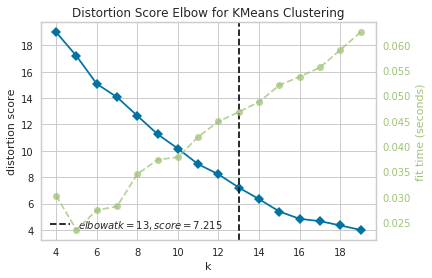

In [55]:
# Use Elbow method to find optimal number of clusters
atl_grouped_clustering = atl_grouped.drop('Neighborhood', 1)

model=KMeans()
visualizer=KElbowVisualizer(model, k=(4,20))  #run for k-values between 4 and 20
visualizer.fit(atl_grouped_clustering)        # Fit the data to the elbow method visualizer
visualizer.show()        # Show the plot and optimal k-value

Based on the elbow method visualizer, I chose to use 13 clusters for my implementation of *k* means clustering.

In [56]:
# set number of clusters based on result of elbow method
kclusters = 13

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(atl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 8,  2,  0, 11,  0,  1,  0,  9,  0,  1], dtype=int32)

In [59]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

atl_merged = atl_final

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
atl_merged = atl_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')



In [60]:
atl_merged.dropna(inplace=True)

In [61]:
atl_merged.head()

,Statistical Area,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,B10,"Peachtree Heights East, Peachtree Hills",33.817221,-84.383298,0.0,American Restaurant,Mediterranean Restaurant,Arts & Crafts Store,Mexican Restaurant,Italian Restaurant,Yoga Studio,Ethiopian Restaurant,History Museum,Greek Restaurant,German Restaurant
3,B02,"Buckhead Forest, South Tuxedo Park",33.846373,-84.384555,1.0,History Museum,Mexican Restaurant,Yoga Studio,Japanese Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
5,B03,East Chastain Park,33.866457,-84.384124,12.0,African Restaurant,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
7,B11,Lindbergh/Morosgo,33.823007,-84.365652,2.0,Fast Food Restaurant,Tapas Restaurant,Restaurant,Thai Restaurant,Asian Restaurant,Italian Restaurant,Dance Studio,History Museum,Greek Restaurant,German Restaurant
8,B07,"Buckhead Village, Peachtree Park",33.838919,-84.367966,0.0,Italian Restaurant,Greek Restaurant,Brazilian Restaurant,New American Restaurant,Design Studio,Indian Restaurant,History Museum,German Restaurant,Fast Food Restaurant,Falafel Restaurant


We create a map that is color-coded by cluster.  This map indicates which neighborhoods have similar venue profiles.  

In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atl_merged['Latitude'], atl_merged['Longitude'], atl_merged['Neighborhood'], atl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analyze clusters to find a suitable location for the restaurant
We look at venues in each cluster to help determine which neighborhoods could support a new restaurant.


In [64]:
atl_merged.loc[atl_merged['Cluster Labels'] == 0, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]]  #Cluster 0 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Peachtree Heights East, Peachtree Hills",American Restaurant,Mediterranean Restaurant,Arts & Crafts Store,Mexican Restaurant,Italian Restaurant,Yoga Studio,Ethiopian Restaurant,History Museum,Greek Restaurant,German Restaurant
8,"Buckhead Village, Peachtree Park",Italian Restaurant,Greek Restaurant,Brazilian Restaurant,New American Restaurant,Design Studio,Indian Restaurant,History Museum,German Restaurant,Fast Food Restaurant,Falafel Restaurant
11,"Castleberry Hill, Downtown",Fast Food Restaurant,American Restaurant,Museum,Mediterranean Restaurant,Mexican Restaurant,Indian Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Vietnamese Restaurant
12,Midtown,American Restaurant,Seafood Restaurant,New American Restaurant,Indian Restaurant,Tex-Mex Restaurant,Italian Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Mediterranean Restaurant,Performing Arts Venue
32,English Avenue,Art Gallery,American Restaurant,Thai Restaurant,Arts & Crafts Store,History Museum,Yoga Studio,Design Studio,Indian Restaurant,Greek Restaurant,German Restaurant
34,Underwood Hills,Italian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,American Restaurant,Art Gallery,Ethiopian Restaurant,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant
59,Airport,American Restaurant,Museum,Fast Food Restaurant,Yoga Studio,Design Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Falafel Restaurant
75,"Atkins Park, Virginia Highland",Restaurant,Japanese Restaurant,Italian Restaurant,American Restaurant,Art Gallery,Design Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant
76,Piedmont Heights,Design Studio,Massage Studio,Tex-Mex Restaurant,Greek Restaurant,Mexican Restaurant,Italian Restaurant,Dance Studio,Yoga Studio,History Museum,German Restaurant
79,"Atlantic Station, Loring Heights",American Restaurant,Restaurant,Science Museum,Dance Studio,Italian Restaurant,Japanese Restaurant,Asian Restaurant,Ethiopian Restaurant,Indian Restaurant,History Museum


In [65]:
atl_merged.loc[atl_merged['Cluster Labels'] == 1, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]]  #Cluster 1 (contains art galleries and museums-may be a good choice for a new restaurant)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Buckhead Forest, South Tuxedo Park",History Museum,Mexican Restaurant,Yoga Studio,Japanese Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
21,"Ashview Heights, Harris Chiles, Just Us",History Museum,Yoga Studio,Dance Studio,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
68,"Baker Hills, Bakers Ferry, Boulder Park, Fairb...",Photography Studio,Yoga Studio,Japanese Restaurant,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
99,"Grant Park, Oakland",History Museum,Ethiopian Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Design Studio


In [66]:
atl_merged.loc[atl_merged['Cluster Labels'] == 2, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Lindbergh/Morosgo,Fast Food Restaurant,Tapas Restaurant,Restaurant,Thai Restaurant,Asian Restaurant,Italian Restaurant,Dance Studio,History Museum,Greek Restaurant,German Restaurant
10,"Georgia Tech, Marietta Street Artery",Fast Food Restaurant,Chinese Restaurant,American Restaurant,Thai Restaurant,Art Gallery,Design Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant
13,Home Park,Italian Restaurant,Fast Food Restaurant,Japanese Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Scandinavian Restaurant,Indian Restaurant,Design Studio,History Museum,Greek Restaurant
19,Westview,Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,New American Restaurant,Indian Restaurant,Dance Studio,Greek Restaurant,German Restaurant
20,West End,Fast Food Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Art Museum,Southern / Soul Food Restaurant,Museum,Yoga Studio,Dance Studio,Greek Restaurant,German Restaurant
58,Greenbriar,Chinese Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Falafel Restaurant,Ethiopian Restaurant
65,"Campbellton Road, Fort Valley, Pomona Park",Fast Food Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
74,"Adamsville, Oakcliff",Fast Food Restaurant,Chinese Restaurant,Seafood Restaurant,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [67]:
atl_merged.loc[atl_merged['Cluster Labels'] == 3, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,Lindridge/Martin Manor,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
95,Lake Claire,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio


Cluster 4, while small, has museums and a wide variety of restaurants.  

In [68]:
atl_merged.loc[atl_merged['Cluster Labels'] == 4, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 4 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Mechanicsville,Restaurant,Japanese Restaurant,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
45,"Capitol Gateway, Summerhill",Restaurant,History Museum,Japanese Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
67,Cascade Avenue/Road,Restaurant,Japanese Restaurant,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio


In [69]:
atl_merged.loc[atl_merged['Cluster Labels'] == 5, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Sylvan Hills,Southern / Soul Food Restaurant,Caribbean Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant
17,"Capitol View, Capitol View Manor",Caribbean Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [70]:
atl_merged.loc[atl_merged['Cluster Labels'] == 6, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,"Fort McPherson, Venetian Hills",Seafood Restaurant,Cajun / Creole Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant
47,Grove Park,Seafood Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [71]:
atl_merged.loc[atl_merged['Cluster Labels'] == 7, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 7

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,"Carver Hills, Rockdale, Scotts Crossing, West ...",American Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
71,"Fairburn Mays, Mays",American Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
91,"East Lake, The Villages at East Lake",American Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


Cluster 8 contains many venues that indicate visitors and residents could support a new restaurant.

In [72]:
atl_merged.loc[atl_merged['Cluster Labels'] == 8, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 8

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Bush Mountain, Oakland City",Art Gallery,Vegetarian / Vegan Restaurant,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant
42,"Adair Park, Pittsburgh",Art Gallery,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
44,Peoplestown,Art Gallery,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
78,East Atlanta,Art Gallery,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
81,"Collier Hills, Collier Hills North, Colonial H...",Art Gallery,Art Museum,Yoga Studio,Design Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant
96,"Chosewood Park, Englewood Manor",Public Art,Art Gallery,Yoga Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
101,"Cabbagetown, Reynoldstown",Art Gallery,Restaurant,American Restaurant,Southern / Soul Food Restaurant,Dance Studio,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant


In [73]:
atl_merged.loc[atl_merged['Cluster Labels'] == 9, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 9

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,"Atlanta University Center, The Villages at Cas...",Art Museum,Yoga Studio,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [74]:
atl_merged.loc[atl_merged['Cluster Labels'] == 10, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 10

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,"Berkeley Park, Blandtown, Hills Park",Dance Studio,Yoga Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
100,Ormewood Park,Dance Studio,Thai Restaurant,Yoga Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [75]:
atl_merged.loc[atl_merged['Cluster Labels'] == 11, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 11

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,"Amal Heights, Betmar LaVilla, High Point, Joyland",Chinese Restaurant,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio


In [76]:
atl_merged.loc[atl_merged['Cluster Labels'] == 12, atl_merged.columns[[1] + list(range(5, atl_merged.shape[1]))]] #Cluster 12

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,East Chastain Park,African Restaurant,Dance Studio,Indian Restaurant,History Museum,Greek Restaurant,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Design Studio
